<div style="border:solid Chocolate 2px; padding: 40px">

<b> Дмитрий, привет!👋</b>

Меня зовут Алексей Гриб, и я буду ревьюером твоего проекта. 

Сразу хочу предложить в дальнейшем общаться на "ты" - надеюсь, так будет комфортнее:) Но если это неудобно, обязательно дай знать, и мы придумаем что-нибудь ещё!
    
Цель ревью - не искать ошибки в твоём проекте, а помочь тебе сделать твою работу ещё лучше, устранив недочёты и приблизив её к реальным задачам специалиста по работе с данными. Поэтому не расстраивайся, если что-то не получилось с первого раза - это нормально, и это поможет тебе вырасти!
    
Ты можешь найти мои комментарии, обозначенные <font color='green'>зеленым</font>, <font color='gold'>желтым</font> и <font color='red'>красным</font> цветами, например:

<br/>

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> похвала, рекомендации «со звёздочкой», полезные лайфхаки, которые сделают и без того красивое решение ещё более элегантным.
</div>

<br/>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> некритичные ошибки или развивающие рекомендации на будущее. 
</div>


<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b>
критичные ошибки, которые обязательно нужно исправить.
</div>

    
Пожалуйста, не удаляй мои комментарии, они будут особенно полезны для нашей работы в случае повторной проверки проекта. 
    
Ты также можешь задавать свои вопросы, реагировать на мои комментарии, делать пометки и пояснения - полная творческая свобода! Но маленькая просьба - пускай они будут отличаться от моих комментариев, это поможет избежать путаницы в нашем общении:)
Например, вот так:
    
<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

*твой текст*
</div>
    
Давай посмотрим на твой проект!

# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:



Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
<b>Все отлично!👍:</b> Хорошее вступление!
    
В нём есть всё, что необходимо, чтобы понять суть проекта с первых строк отчёта!

In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
!pip install sqlalchemy
#!pip install psycopg2 #### на рабочем компе не устанавливается, хотя в Spyder спокойно работает. На домашнем ноуте - все ок

In [4]:
!pip install phik

In [5]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from phik import phik_matrix
from scipy import stats

In [ ]:
import os
from dotenv import load_dotenv

In [ ]:
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")



In [7]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    DB_USER,
    DB_PASSWORD,
    DB_HOST,
    DB_PORT,
    DB_NAME,

)

In [8]:
engine = create_engine(connection_string)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Библиотеки импортировали, коннектор сделали - отлично!

In [9]:
tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [10]:
query = '''
SELECT 
	p.user_id, p.device_type_canonical,	p.order_id, p.created_dt_msk::date order_dt, p.created_ts_msk order_ts, p.currency_code, p.revenue, p.tickets_count,
	EXTRACT (DAY FROM p.created_dt_msk - lag(p.created_dt_msk) over(PARTITION BY p.user_id ORDER BY p.created_dt_msk)) days_since_prev,
	p.event_id, e.event_name_code event_name, p.service_name, e.event_type_main, r.region_name, c.city_name
FROM afisha.purchases p JOIN afisha.events e using(event_id) JOIN afisha.city c using(city_id) JOIN afisha.regions r using(region_id)
WHERE device_type_canonical IN ('mobile','desktop') 
	AND event_type_main <> 'фильм'
ORDER BY user_id;
'''

In [11]:
df = pd.read_sql_query(query, con=engine)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Данные выгружены из базы.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Запросы следует делать более читаемыми. Например, ресурс https://sqlformat.org/ автоматически преобразует написанный SQL-запрос в унифицированный формат в зависимости от выбранного диалекта SQL, это помогает придать запросу более читабельный вид и повышает его читабельность.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Да, запрос изначально был написан читаемом виде. Это всё следствие многолетней привычки экономить место на экране
</div>

In [12]:
df.info()
display(df.head(10))
tenge.info()
display(tenge.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  object        
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  event_type_main        290611 non-null  obje

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,Мой билет,выставки,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,Билеты без проблем,стендап,Озернинский край,Родниковецк
5,000898990054619,mobile,2613713,2024-10-23,2024-10-23 15:12:00,rub,902.74,3,19.0,500862,9cc55c15-4375-4129-9979-3129688ba1b4,Облачко,концерты,Лугоградская область,Кристалевск
6,00096d1f542ab2b,desktop,6636941,2024-08-15,2024-08-15 16:48:48,rub,917.83,4,NaN,201953,2f98d69f-4e60-4ffc-8f16-e539383526b1,Край билетов,театр,Каменевский регион,Глиногорск
7,000a55a418c128c,mobile,4657981,2024-09-29,2024-09-29 19:39:12,rub,47.78,1,NaN,265857,0d876e01-851e-458b-ba61-753e0e0c4063,Лучшие билеты,театр,Поленовский край,Дальнозолотск
8,000a55a418c128c,mobile,4657952,2024-10-15,2024-10-15 10:29:04,rub,74.84,2,16.0,271579,ddc795f8-7ef8-4eb0-b299-cb3e6ee24ba1,Лучшие билеты,театр,Поленовский край,Дальнозолотск
9,000cf0659a9f40f,mobile,6818191,2024-06-20,2024-06-20 10:51:10,rub,1421.91,4,NaN,516728,11be386f-7cb7-4aa1-a8e4-ba73a29c1af2,Лови билет!,концерты,Широковская область,Радужнополье


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt
5,2024-01-15,100,19.4501,kzt
6,2024-01-16,100,19.4264,kzt
7,2024-01-17,100,19.4177,kzt
8,2024-01-18,100,19.5798,kzt
9,2024-01-19,100,19.5741,kzt


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Метод `.print()` не очень подходит для работы с таблицами типа `pd.DataFrame`, так как выводит их на экран просто как отформатированный текст. Для отображения небольших таблиц можно воспользоваться методом `.head()`, для таблиц побольше - модулем `display`.
        
</div>

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Исправил
    </div>

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

Информация о датафреймах приведена выше. 290611 строк в основной выгрузке. 357 - в выгрузке с сайта ЦБ. В целом данные выгружены верно. Типы определены корректно, кроме даты order_dt и data в первом и втором датафрейме. Проверки пропусков осуществлялись на этапе разработки запроса. 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Первичный осмотр данных выполнен.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Нужно наметить шаги по их обработке.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Шаги ниже:
</div>

Шаги:
1. Корректировка типов данных. Не требуется. Данные определились корректно.
2. Проверка на выбросы и аномальные значения.
3. Обработка выбросов в зависимости от их значений
4. объединение датасетов
5. пересчет выручки в соответствии с курсом
6. проверка значений в новых полях

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


Конвертируем типы данных в полях с датами и объединим два датафрема. После объединения расчитаем значения нового поля - `revenue_rub`.

In [13]:
df['order_dt'] = pd.to_datetime(df['order_dt'], errors='coerce', format='%Y-%m-%d')
tenge['data'] = pd.to_datetime(tenge['data'], errors='coerce', format='%Y-%m-%d')

In [14]:
main = pd.merge(df, tenge, left_on='order_dt', right_on='data', how='left') #left - чтобы не терять строки
main.loc[main['currency_code'] == 'kzt', 'revenue_rub'] = main['revenue'] / main['nominal'] * main['curs']
main.loc[main['currency_code'] != 'kzt', 'revenue_rub'] = main['revenue']

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Выручка приведена к единой валюте.

Итоги конвертации и проверка нового поля на пропуски:

In [15]:
display(main[['currency_code','curs','revenue','revenue_rub']].loc[main['currency_code'] == 'kzt'].head(10))
display(main[['currency_code','curs','revenue','revenue_rub']].loc[main['currency_code'] == 'rub'].head(10))
display(main.isnull().sum())

,currency_code,curs,revenue,revenue_rub
70,kzt,19.0125,518.10,98.503762
89,kzt,18.9330,347.18,65.731589
96,kzt,18.5991,328.77,61.148261
277,kzt,19.8928,22021.55,4380.702898
460,kzt,19.9833,7397.66,1478.296591
461,kzt,19.9833,7397.66,1478.296591
462,kzt,19.9833,5548.24,1108.721444
463,kzt,19.9833,3698.83,739.148295
464,kzt,19.9833,7397.66,1478.296591
515,kzt,18.4217,361.08,66.517074


,currency_code,curs,revenue,revenue_rub
0,rub,18.6972,1521.94,1521.94
1,rub,18.3419,289.45,289.45
2,rub,19.6475,1258.57,1258.57
3,rub,18.5010,8.49,8.49
4,rub,19.6648,1390.41,1390.41
5,rub,20.0531,902.74,902.74
6,rub,18.7730,917.83,917.83
7,rub,19.3741,47.78,47.78
8,rub,19.7185,74.84,74.84
9,rub,18.0419,1421.91,1421.91


user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
service_name                 0
event_type_main              0
region_name                  0
city_name                    0
data                         0
nominal                      0
curs                         0
cdx                          0
revenue_rub                  0
dtype: int64

Пропуски - только в поле days-since_prev. Конертация курсов прошла успешно.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Изучены пропуски - всё ожидаемо.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Пропуски - только в `days_since_prev` - установлено ранее. Типы преобразованы. Лишние поля - удаляем.

In [16]:
main = main.drop(['curs','cdx','data','currency_code','revenue','nominal'], axis=1)
main.head(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,Мой билет,выставки,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,Билеты без проблем,стендап,Озернинский край,Родниковецк,1390.41


In [17]:
print(pd.unique(main['event_type_main']))
print(pd.unique(main['service_name']))
display(main['event_type_main'].value_counts())
# display(main['service_name'].value_counts())

['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет' 'Цвет и билет' 'Зе Бест!'
 'Тех билет' 'Лимоны' 'Билеты в интернете']


концерты    115276
театр        67321
другое       65867
спорт        21911
стендап      13393
выставки      4854
ёлки          1989
Name: event_type_main, dtype: int64

Явных существенных ошибок в данных не зафиксировано. В поле event_type_main значение "другое" может использоваться в качестве заглушки. Уникальность городов, регионов, операторов проверялась на этапе разработки запроса. На случай, если в этих полях все жеимеются неявные дубликаты, приведем их в upper case и удалим явные дубликаты

In [18]:
main['service_name_upper'] = main['service_name'].str.upper()
main['region_name_upper'] = main['region_name'].str.upper()
main['city_name_upper'] = main['city_name'].str.upper()

In [19]:
d_subset=['user_id','device_type_canonical','order_id','tickets_count','event_id','event_name',
          'service_name_upper','region_name_upper','city_name_upper']
main['is_duplicated'] = main.duplicated(subset=d_subset, keep='first')
print('Дублирующиеся строки:')
print(main['is_duplicated'].value_counts())
main[main['is_duplicated']]

Дублирующиеся строки:
False    290611
Name: is_duplicated, dtype: int64


,user_id,device_type_canonical,order_id,order_dt,order_ts,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name,revenue_rub,service_name_upper,region_name_upper,city_name_upper,is_duplicated


Дублированных строк нет. Удалим поля с upper_case

In [20]:
main = main.drop(['service_name_upper','region_name_upper','city_name_upper','is_duplicated'], axis=1)
main.head(5)

,user_id,device_type_canonical,order_id,order_dt,order_ts,tickets_count,days_since_prev,event_id,event_name,service_name,event_type_main,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,Край билетов,театр,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,Мой билет,выставки,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,За билетом!,другое,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,Лови билет!,другое,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,Билеты без проблем,стендап,Озернинский край,Родниковецк,1390.41


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Категориальные признаки проверены на предмет аномалий.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Проверить нужно все признаки, задействованные в проекте. 

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
    Так все же поля проверены на пропуски и неявные дублирования. event_name нам здесь вообще не нужен. все заказы - с уникальными order_id. Далее, все новые поля тоже проверяю на правильность заполнения.

</div>

In [21]:
main['order_id'].value_counts().sum()

290611

Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.

Важные показатели в рамках поставленной задачи — это выручка с заказа (revenue_rub) и количество билетов в заказе (tickets_count), поэтому в первую очередь проверьте данные в этих столбцах.

Если обнаружите выбросы в поле revenue_rub, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

Сводные таблицы cо средним, минимальным, максимальным значениями (для экономии места и читаемости вывод некоторых представлений сводных таблиц закомментирован):

In [22]:
main['ticket_price'] = main['revenue_rub']/main['tickets_count']
main_pivot_event = main.pivot_table(values='revenue_rub', index='event_type_main', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_region = main.pivot_table(values='revenue_rub', index='region_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_city = main.pivot_table(values='revenue_rub', index='city_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_operator = main.pivot_table(values='revenue_rub', index='service_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_event[['min','max','mean','count','sum','median']]

,min,max,mean,count,sum,median
,revenue_rub,revenue_rub,revenue_rub,revenue_rub,revenue_rub,revenue_rub
event_type_main,,,,,,
выставки,-6.33,3656.87,232.871844,4854,1.130360e+06,157.55
другое,-17.94,6414.34,238.235437,65867,1.569185e+07,95.04
концерты,-5.70,81174.54,807.912260,115276,9.313289e+07,666.90
спорт,-90.76,18641.92,160.156237,21911,3.509183e+06,96.13
стендап,3.97,24680.88,711.575999,13393,9.530137e+06,537.80
театр,0.00,8161.31,548.467897,67321,3.692341e+07,356.83
ёлки,26.02,4362.15,772.999211,1989,1.537495e+06,606.41


In [23]:
main_pivot_event_t = main.pivot_table(values='tickets_count', index='event_type_main', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_region_t = main.pivot_table(values='tickets_count', index='region_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_city_t = main.pivot_table(values='tickets_count', index='city_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_operator_t = main.pivot_table(values='tickets_count', index='service_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_event_t[['min','max','mean','count','sum','median']]

,min,max,mean,count,sum,median
,tickets_count,tickets_count,tickets_count,tickets_count,tickets_count,tickets_count
event_type_main,,,,,,
выставки,1,6,2.556654,4854,12410,3
другое,1,57,2.769642,65867,182428,3
концерты,1,12,2.656086,115276,306183,3
спорт,1,47,3.053215,21911,66899,3
стендап,1,6,2.992309,13393,40076,3
театр,1,19,2.759674,67321,185784,3
ёлки,1,8,3.344897,1989,6653,3


In [24]:
main_pivot_event_tp    = main.pivot_table(values='ticket_price', index='event_type_main', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_region_tp   = main.pivot_table(values='ticket_price', index='region_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_city_tp     = main.pivot_table(values='ticket_price', index='city_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_operator_tp = main.pivot_table(values='ticket_price', index='service_name', aggfunc=['mean','min','max','count','sum','median'])
main_pivot_event_tp[['min','max','mean','count','sum','median']]

,min,max,mean,count,sum,median
,ticket_price,ticket_price,ticket_price,ticket_price,ticket_price,ticket_price
event_type_main,,,,,,
выставки,-1.385,1500.080000,88.737251,4854,4.307306e+05,67.003333
другое,-3.670,1603.585000,79.077758,65867,5.208615e+06,36.160000
концерты,-5.700,21757.540000,301.208430,115276,3.472210e+07,280.420000
спорт,-18.152,3728.385000,52.404560,21911,1.148236e+06,35.380000
стендап,3.465,4936.177500,239.022379,13393,3.201227e+06,199.483333
театр,0.000,2720.436667,197.248387,67321,1.327896e+07,142.340000
ёлки,24.100,858.106667,240.315850,1989,4.779882e+05,196.500000


Присутствуют выбросы - очень дорогие заказы по 81 тыс. руб. (уже позже посчитал цену билета - 21.8 тыс. руб., также можно ситать выбросом - т.е. это не влияние большого количества билетов в заказе.)

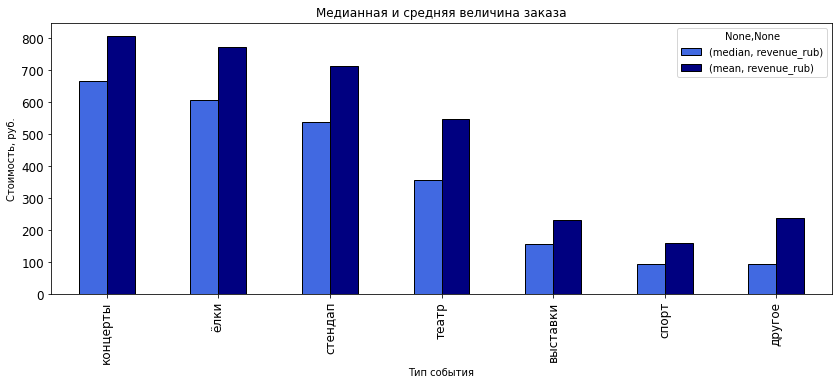

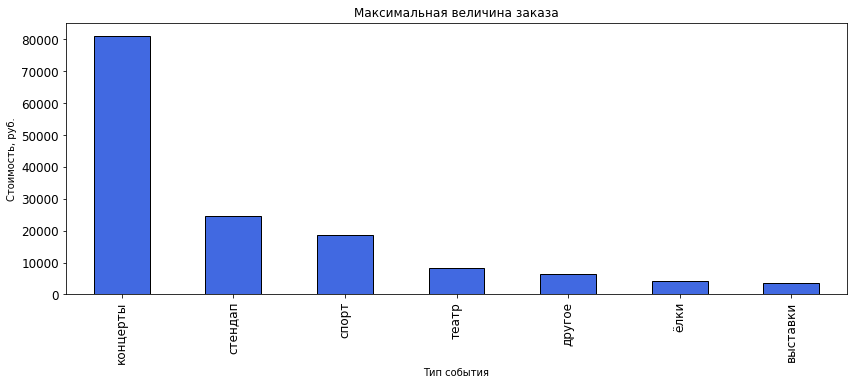

In [25]:
a = main_pivot_event[['median','mean']]
b = main_pivot_event[['max']]
a.sort_values(by=a.columns[0],ascending=False).plot(kind='bar', xlabel='Тип события', ylabel='Стоимость, руб.', legend=True
                 , rot=90, 
    title='Медианная и средняя величина заказа', 
    figsize=(14,5),
    fontsize = 12,
    color = ['royalblue','navy'],
    edgecolor='black'
    )
plt.show()
b.sort_values(by=b.columns[0],ascending=False).plot(kind='bar', xlabel='Тип события', ylabel='Стоимость, руб.', legend=False
                 , rot=90, 
    title='Максимальная величина заказа', 
    figsize=(14,5),
    fontsize = 12,
    color = ['royalblue','navy'],
    edgecolor='black'
    )
plt.show()

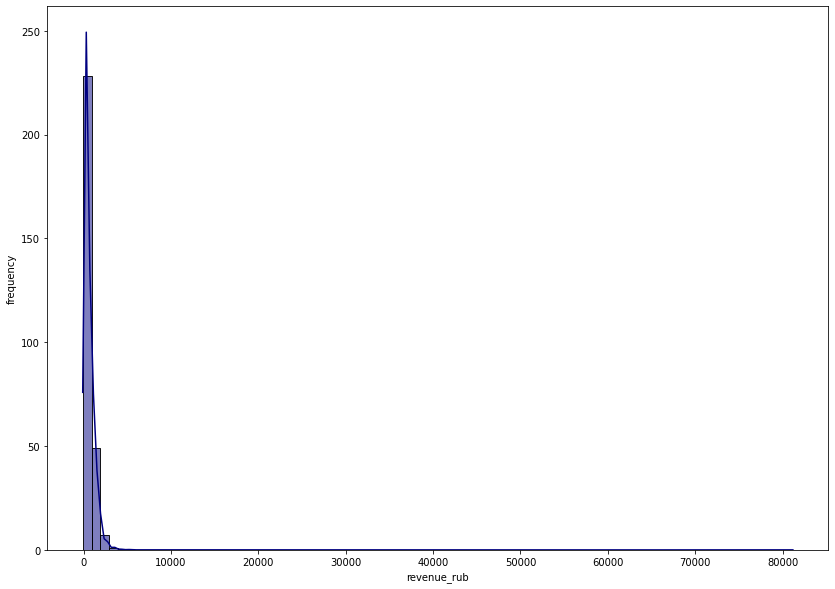

In [26]:
#Гистограммы
plt.figure(figsize=(14,10))
sns.histplot(data=main, x='revenue_rub', bins=80, kde=True, stat='frequency', color='navy')
plt.xlabel('revenue_rub')
plt.ylabel('frequency')
plt.show()

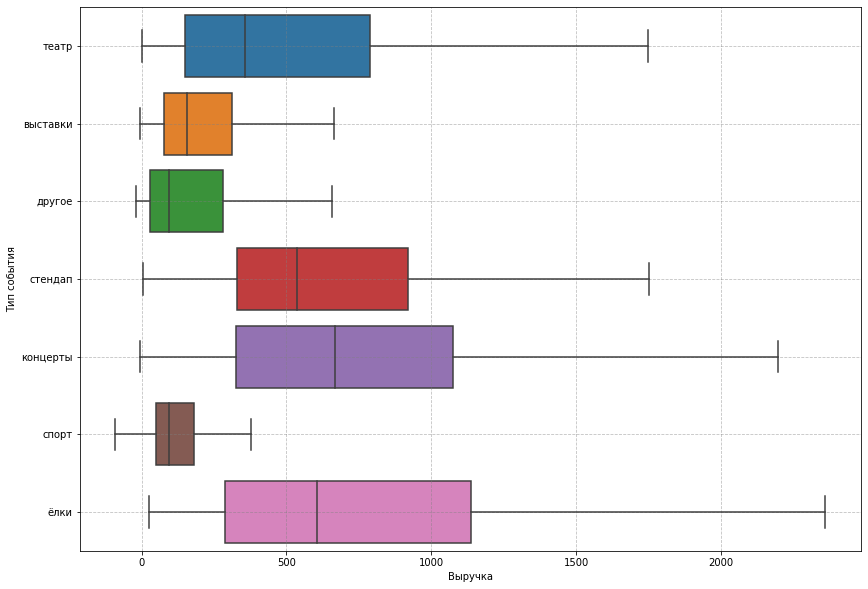

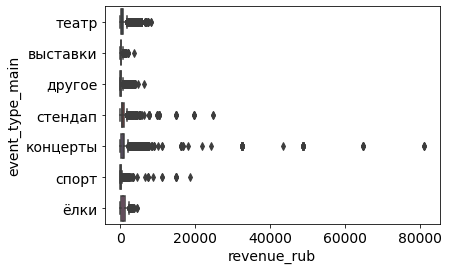

In [27]:
plt.figure(figsize=(14, 10)) 
# sns.boxplot(data=main, y='event_type_main', x='revenue_rub', showfliers=True)
sns.boxplot(data=main, y='event_type_main', x='revenue_rub', showfliers=False)
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
plt.ylabel('Тип события')
plt.xlabel('Выручка')
plt.show()
sns.boxplot(data=main, y='event_type_main', x='revenue_rub', showfliers=True)
plt.show()

Отфильтруем датафрейм по 99 квантилю по полю revenue_rub

In [28]:
threshold = main['revenue_rub'].quantile(0.99)
# Фильтруем: оставляем только строки, где value ≤ 99-му перцентилю
main_f = main[main['revenue_rub'] <= threshold]

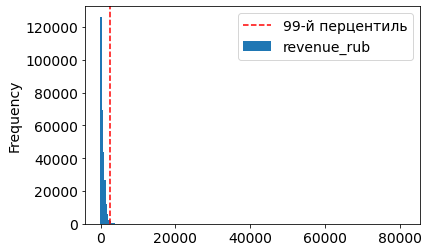

In [29]:
main['revenue_rub'].plot(kind='hist', bins=222)
plt.axvline(threshold, color='red', linestyle='--', label='99-й перцентиль')
plt.legend()

In [30]:
print('Отфильтровано строк: ',main.shape[0]-main_f.shape[0])

Отфильтровано строк:  2825


Посмотрим, как поменялась гистограмма (график по городам и регионам аналогичен, но из-за большого количества сущностей плохо читаем, плюс экономлю время):

In [31]:
# main_f_pivot_event = main_f.pivot_table(values='revenue_rub', index='event_type_main', aggfunc=['mean','min','max','count','sum','median'])
# c = main_f_pivot_event[['median','mean']]
# d = main_f_pivot_event[['max']]
# c.sort_values(by=c.columns[0],ascending=False).plot(kind='bar', xlabel='Тип события', ylabel='Стоимость, руб.', legend=True
#                  , rot=90, 
#     title='Медианная и средняя величина заказа', 
#     figsize=(14,5),
#     fontsize = 12,
#     color = ['royalblue','navy'],
#     edgecolor='black'
#     )
# plt.show()
# d.sort_values(by=d.columns[0],ascending=False).plot(kind='bar', xlabel='Тип события', ylabel='Стоимость, руб.', legend=False
#                  , rot=90, 
#     title='Максимальная величина заказа', 
#     figsize=(14,5),
#     fontsize = 12,
#     color = ['royalblue','navy'],
#     edgecolor='black'
#     )
# plt.show()

После фильтрации по 99 квантилю распределение данных по заказам стало более равномерным по разным типам событий.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> На данном этапе нужно только изучить выбросы без дополнительного улгубления в анализ по категориям, в противном случае возникает вопрос полноты покрытия - почему только тип события без остальных категорий?

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Тут логика следующая: мы обнаружили выбросы в поле стоимость. Нарисовали боксплоты в двух вариантах - с отображением выбросов и без их отображения. Далее я рисую гистограммы, чтобы посмотреть, как данные изменились после удаления выбросов. Перед графиками я сделал пометку, что оставлю только график по типам мероприятий для экономии места. Т.к. да, в этом разеделе эти графики не требуются. В строке перед графиками код написан так, чтобы можно было просто заменить только поле `event_type_main` на другое, тогда и гистограмма будет обновлена соответствующим образом. 
    
Код оставлю, но закомментирую. 

</div>

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [32]:
#backup датафрейма
df = main.copy()
# Сначала сортируем по user_id и времени заказа (order_ts)
profile = df.sort_values(['user_id', 'order_ts']).reset_index(drop=True)

# Группируем по user_id и агрегируем
profile = profile.groupby('user_id', sort=False).agg(
    first_order_dt=('order_dt', 'min'),          # дата первого заказа
    last_order_dt=('order_dt', 'max'),           # дата последнего заказа
    
    # Первый заказ: берём значения первой строки в группе (после сортировки)
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_service=('service_name', 'first'),
    first_event_type=('event_type_main', 'first'),
    
    total_orders=('order_id', 'count'),          # общее количество заказов
    avg_revenue_rub=('revenue_rub', 'mean'),     # средняя выручка в рублях
    avg_tickets_per_order=('tickets_count', 'mean'),  # среднее количество билетов
    avg_days_between_orders=('days_since_prev', 'mean')  # среднее время между заказами (NULL/NaN игнорируются
).reset_index()

# Добавляем бинарные признаки
profile['is_two'] = (profile['total_orders'] >= 2).astype(int)
profile['is_five'] = (profile['total_orders'] >= 5).astype(int)

In [33]:
profile.info()
display(profile.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21933 entries, 0 to 21932
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21933 non-null  object        
 1   first_order_dt           21933 non-null  datetime64[ns]
 2   last_order_dt            21933 non-null  datetime64[ns]
 3   first_device             21933 non-null  object        
 4   first_region             21933 non-null  object        
 5   first_service            21933 non-null  object        
 6   first_event_type         21933 non-null  object        
 7   total_orders             21933 non-null  int64         
 8   avg_revenue_rub          21933 non-null  float64       
 9   avg_tickets_per_order    21933 non-null  float64       
 10  avg_days_between_orders  13559 non-null  float64       
 11  is_two                   21933 non-null  int64         
 12  is_five                  21933 n

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_per_order,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.000000,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.000000,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.000000,1,0
5,000cf0659a9f40f,2024-06-20,2024-06-21,mobile,Широковская область,Лови билет!,концерты,13,1175.808462,3.307692,0.083333,1,1
6,00147c9209d45d3,2024-06-25,2024-06-25,mobile,Каменевский регион,Облачко,концерты,2,352.945000,1.500000,0.000000,1,0
7,0018ecd8a38a51b,2024-07-25,2024-07-25,mobile,Медовская область,Билеты без проблем,спорт,1,0.000000,3.000000,NaN,0,0
8,00199a573901564,2024-06-17,2024-06-17,mobile,Каменевский регион,Билеты без проблем,концерты,1,588.120000,4.000000,NaN,0,0
9,001e7037d013f0f,2024-07-04,2024-09-29,mobile,Златопольский округ,Мой билет,другое,3,326.623333,1.333333,43.500000,1,0


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Профиль пользователя собран, добавлены новые признаки.

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [34]:
user_count = profile['user_id'].value_counts().sum()
avg_order_rev = (profile['total_orders']*profile['avg_revenue_rub']).sum()/(profile['total_orders'].sum())
is_two_share = profile['is_two'].sum()/profile.shape[0]
is_five_share = profile['is_five'].sum()/profile.shape[0]
print('Общее число пользователей в выборке: ', user_count)
print('Средняя выручка с одного заказа: ', round(avg_order_rev,2), 'руб.')
print('Доля пользователей, совершивших 2 и более заказа: ', round(is_two_share,2))
print('Доля пользователей, совершивших 5 и более заказов: ', round(is_five_share,2))

Общее число пользователей в выборке:  21933
Средняя выручка с одного заказа:  555.57 руб.
Доля пользователей, совершивших 2 и более заказа:  0.62
Доля пользователей, совершивших 5 и более заказов:  0.29


In [35]:
# Также изучите статистические показатели:
# по общему числу заказов; total_orders
# по среднему числу билетов в заказе; avg_tickets_per_order
# по среднему количеству дней между покупками. avg_days_between_orders

In [36]:
print('total_orders:')
print('Мин:',     profile['total_orders'].min())
print('Макс:',    profile['total_orders'].max())
print('Среднее:', profile['total_orders'].mean())
print('Медиана:', profile['total_orders'].median())
print()
print('avg_tickets_per_order:')
print('Мин:',     profile['avg_tickets_per_order'].min())
print('Макс:',    profile['avg_tickets_per_order'].max())
print('Среднее:', profile['avg_tickets_per_order'].mean())
print('Медиана:', profile['avg_tickets_per_order'].median())
print()
print('avg_days_between_orders:')
print('Мин:',     profile['avg_days_between_orders'].min())
print('Макс:',    profile['avg_days_between_orders'].max())
print('Среднее:', profile['avg_days_between_orders'].mean())
print('Медиана:', profile['avg_days_between_orders'].median())

total_orders:
Мин: 1
Макс: 10251
Среднее: 13.249943008252405
Медиана: 2.0

avg_tickets_per_order:
Мин: 1.0
Макс: 12.0
Среднее: 2.755987073396934
Медиана: 2.7641509433962264

avg_days_between_orders:
Мин: 0.0
Макс: 148.0
Среднее: 15.808536543389545
Медиана: 8.0


In [37]:
profile_sorted = profile.sort_values(['total_orders'], ascending = False)#.reset_index(drop=True)
profile_sorted

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_per_order,avg_days_between_orders,is_two,is_five
985,0beb8fc0c0a9ce1,2024-06-01,2024-10-31,mobile,Североярская область,Билеты в руки,концерты,10251,523.376768,2.873964,0.014829,1,1
2061,18e9aead0a393e7,2024-06-01,2024-10-31,mobile,Каменевский регион,Облачко,концерты,4368,508.101194,2.794643,0.034807,1,1
11114,8187dac4be757a0,2024-06-01,2024-10-31,mobile,Берёзовская область,Билеты в руки,концерты,4053,571.896656,2.756970,0.037512,1,1
5432,3ee7dc2e115847f,2024-06-01,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,3826,570.638953,2.776529,0.039739,1,1
10849,7eb4fc207ecc10f,2024-06-01,2024-10-31,mobile,Каменевский регион,Билеты без проблем,театр,3749,570.740409,2.972259,0.040555,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10623,7c0f1cdb436ce17,2024-10-31,2024-10-31,mobile,Каменевский регион,Радио ticket,другое,1,34.200000,2.000000,NaN,0,0
10626,7c158eb0fb1a02c,2024-07-30,2024-07-30,mobile,Травяная область,Лови билет!,другое,1,155.240000,2.000000,NaN,0,0
10627,7c1908cb4b166c1,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,1,80.620000,1.000000,NaN,0,0
10628,7c1cf2fdeea43b2,2024-07-30,2024-07-30,mobile,Североярская область,Лови билет!,другое,1,31.580000,3.000000,NaN,0,0


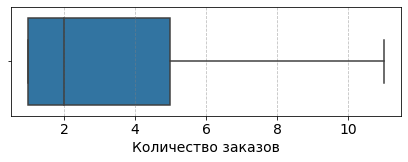

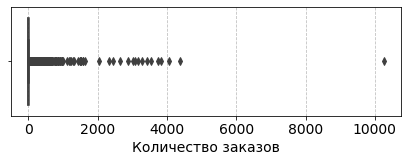

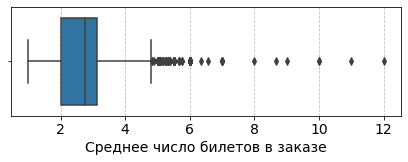

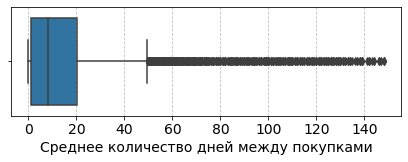

In [38]:
plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile, x='total_orders', showfliers=False)
plt.xlabel('Количество заказов')
plt.show()
plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile, x='total_orders', showfliers=True)
plt.xlabel('Количество заказов')
plt.show()

plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile, x='avg_tickets_per_order', showfliers=True)
plt.xlabel('Среднее число билетов в заказе')
plt.show()

plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile, x='avg_days_between_orders', showfliers=True)
plt.xlabel('Среднее количество дней между покупками')
plt.show()

Боксплоты со включенной опцией отображения выбросов (showfliers=True) показывают наличие выбросов по всем исследумеым полям. Однако, представляется, что выбросы в полях "среднее число билетов в заказе" и "среднее количество дней" можно оставить, т.к. они, вероятно, не являются аномалией (либо являются, но не во всех случаях): кто-то может покупать 5-12 билетов на компанию из нескольких человек, посещать мероприятия реже 50 дней.  
Обращает на себя внимание наличие пользователей с большим количеством заказов. Обычное количество заказов - до 5. Иногда - 11. Тем не менее, существуют пользователи с заказами в несколько тысяч (до 10) билетов. Вероятно, это корпоративные покупатели, агентства и т.п.  Скорее всего, они не нужны в исследовании и их можно исключить. Последовательно отфильтруем датафрейм по 99 и 95 процентилю. После фильтрации посмотрим, как изменятся боксплоты.

In [39]:
threshold99 = profile['total_orders'].quantile(0.99)
threshold95 = profile['total_orders'].quantile(0.95)

In [40]:
profile99 = profile[profile['total_orders'] <= threshold99]
profile95 = profile[profile['total_orders'] <= threshold95]

In [41]:
print(f'Удалено строк, 99% {profile.shape[0]-profile99.shape[0]}. Осталось {profile99.shape[0]} строк.')
print(f'Удалено строк, 95% {profile.shape[0]-profile95.shape[0]}. Осталось {profile95.shape[0]} строк.')

Удалено строк, 99% 219. Осталось 21714 строк.
Удалено строк, 95% 1069. Осталось 20864 строк.


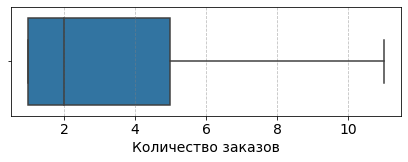

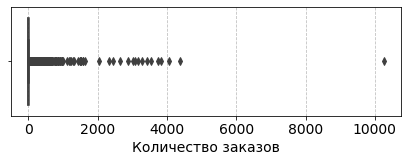

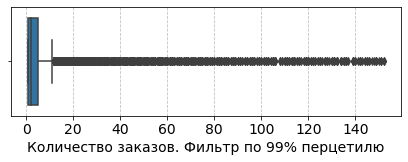

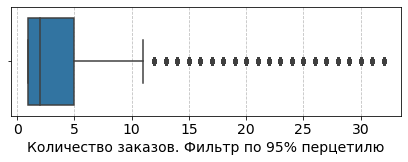

In [42]:
plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile, x='total_orders', showfliers=False)
plt.xlabel('Количество заказов')
plt.show()
plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile, x='total_orders', showfliers=True)
plt.xlabel('Количество заказов')
plt.show()

plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile99, x='total_orders', showfliers=True)
plt.xlabel('Количество заказов. Фильтр по 99% перцетилю')
plt.show()

plt.figure(figsize=(7, 2)) 
plt.rc('font',size=14)
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.boxplot(data=profile95, x='total_orders', showfliers=True)
plt.xlabel('Количество заказов. Фильтр по 95% перцетилю')
plt.show()

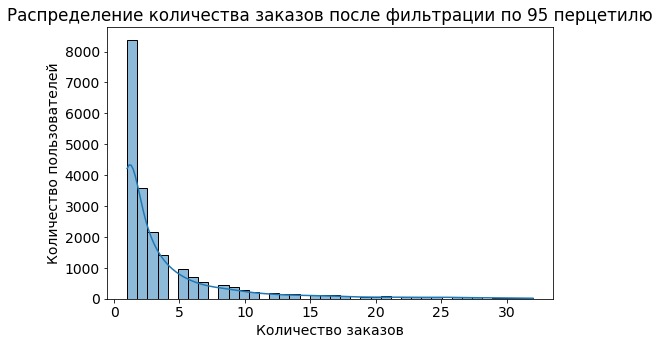

In [43]:
#гистограмма95
plt.figure(figsize=(8,5))
sns.histplot(data=profile95, x='total_orders', stat='count', bins=40, kde=True)
plt.fontsize=14
plt.title('Распределение количества заказов после фильтрации по 95 перцетилю')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.show()

После фильтрации выбросы по количеству заказов не пропадают полностью, но их количество существенно сокращается, и, как видно из гистограммы выше, в целом таких пользователей немного. Можно оставаить фильтрацию по 95% перцентилю. Доступных данных достаточно для анализа.

In [44]:
df = profile95.copy() #сохраняем финальный датафрейм для анализа
df.head(5)

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_per_order,avg_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0,1,0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0,1,0


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

Делая копию или срез какой-то таблицы, стоит использовать метод `copy()`: используя простое присвивание вида `a=b`, мы в переменную `a` помещаем не новый и самостоятельный объект в памяти, а всего лишь новую ссылку на объект в памяти, на который ссылается `b`. Как итог, внеся изменения в `a`, ты увидишь их и в `b`, и наоборот. Метод `copy()` позволяет создавать именно новые объекты в памяти.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Вероятно сказывается влияние других языков программирования)
Везде или почти везде поправил это. В следующий раз буду учитывать.

</div>

In [45]:
print('Обновленные данные после фильтрации по 95 процентилю:')
print()
user_count = profile95['user_id'].value_counts().sum()
avg_order_rev = (profile95['total_orders']*profile95['avg_revenue_rub']).sum()/(profile95['total_orders'].sum())
is_two_share = profile95['is_two'].sum()/profile95.shape[0]
is_five_share = profile95['is_five'].sum()/profile95.shape[0]
print('Общее число пользователей в выборке: ', user_count)
print('Средняя выручка с одного заказа: ', round(avg_order_rev,2), 'руб.')
print('Доля пользователей, совершивших 2 и более заказа: ', round(is_two_share,2))
print('Доля пользователей, совершивших 5 и более заказов: ', round(is_five_share,2))
print('total_orders:')
print('Мин:',     profile95['total_orders'].min())
print('Макс:',    profile95['total_orders'].max())
print('Среднее:', profile95['total_orders'].mean())
print('Медиана:', profile95['total_orders'].median())
print()
print('avg_tickets_per_order:')
print('Мин:',     profile95['avg_tickets_per_order'].min())
print('Макс:',    profile95['avg_tickets_per_order'].max())
print('Среднее:', profile95['avg_tickets_per_order'].mean())
print('Медиана:', profile95['avg_tickets_per_order'].median())
print()
print('avg_days_between_orders:')
print('Мин:',     profile95['avg_days_between_orders'].min())
print('Макс:',    profile95['avg_days_between_orders'].max())
print('Среднее:', profile95['avg_days_between_orders'].mean())
print('Медиана:', profile95['avg_days_between_orders'].median())

Обновленные данные после фильтрации по 95 процентилю:

Общее число пользователей в выборке:  20864
Средняя выручка с одного заказа:  581.11 руб.
Доля пользователей, совершивших 2 и более заказа:  0.6
Доля пользователей, совершивших 5 и более заказов:  0.26
total_orders:
Мин: 1
Макс: 32
Среднее: 4.108080904907975
Медиана: 2.0

avg_tickets_per_order:
Мин: 1.0
Макс: 12.0
Среднее: 2.756519755964938
Медиана: 2.7777777777777777

avg_days_between_orders:
Мин: 0.0
Макс: 148.0
Среднее: 16.98027555988488
Медиана: 9.414285714285715


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Изучены статистики по профилю пользователя, удалены выбросы.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


Рассчитаем сводные таблицы по группам пользователей. Учитывая задания из следующей задачи сразу посчитаем долю пользователей, совершивших два и более заказов

In [46]:
pt = pd.pivot_table(data=df, index='first_event_type', values=['total_orders'], columns='is_two', aggfunc=['count'] )
events = pd.DataFrame(pt)
events[('count', 'total_orders', 'total')] = events[('count', 'total_orders', 0)]+events[('count', 'total_orders', 1)]
events[('count', 'total_orders', 'share2')] = events[('count', 'total_orders', 1)]/(events[('count', 'total_orders', 0)]+events[('count', 'total_orders', 1)])
events[('count', 'total_orders', 'share_tot')] = (events[('count', 'total_orders', 0)]+events[('count', 'total_orders', 1)])/(events[('count', 'total_orders', 'total')].sum())


In [47]:
pt = pd.pivot_table(data=df, index='first_device', values=['total_orders'], columns='is_two', aggfunc=['count'] )
device = pd.DataFrame(pt)
device[('count', 'total_orders', 'total')] = device[('count', 'total_orders', 0)]+device[('count', 'total_orders', 1)]
device[('count', 'total_orders', 'share2')] = device[('count', 'total_orders', 1)]/(device[('count', 'total_orders', 0)]+device[('count', 'total_orders', 1)])
device[('count', 'total_orders', 'share_tot')] = (device[('count', 'total_orders', 0)]+device[('count', 'total_orders', 1)])/(device[('count', 'total_orders', 'total')].sum())


In [48]:
pt = pd.pivot_table(data=df, index='first_region', values=['total_orders'], columns='is_two', aggfunc=['count'] )
region = pd.DataFrame(pt)
region[('count', 'total_orders', 'total')] = region[('count', 'total_orders', 0)]+region[('count', 'total_orders', 1)]
region[('count', 'total_orders', 'share2')] = region[('count', 'total_orders', 1)]/(region[('count', 'total_orders', 0)]+region[('count', 'total_orders', 1)])
region[('count', 'total_orders', 'share_tot')] = (region[('count', 'total_orders', 0)]+region[('count', 'total_orders', 1)])/(region[('count', 'total_orders', 'total')].sum())
region=region.sort_values(by=region.columns[2], ascending=False)#.head(10)
region10=region.sort_values(by=region.columns[2], ascending=False).head(10)

In [49]:
pt = pd.pivot_table(data=df, index='first_service', values=['total_orders'], columns='is_two', aggfunc=['count'] )
service = pd.DataFrame(pt)
service[('count', 'total_orders', 'total')] = service[('count', 'total_orders', 0)]+service[('count', 'total_orders', 1)]
service[('count', 'total_orders', 'share2')] = service[('count', 'total_orders', 1)]/(service[('count', 'total_orders', 0)]+service[('count', 'total_orders', 1)])
service[('count', 'total_orders', 'share_tot')] = (service[('count', 'total_orders', 0)]+service[('count', 'total_orders', 1)])/(service[('count', 'total_orders', 'total')].sum())
service=service.sort_values(by=service.columns[2], ascending=False)#.head(10)
service10=service.sort_values(by=service.columns[2], ascending=False).head(10)


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Тут и далее следует давать переменным информативные имена - сейчас без анализа кода нельзя понять, что содержится в переменных.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
ок. тут снова привычка сокращать место: 
    PT - pivot table
    DF - dataframe
    суффиксы - первые буквы исследуемых полей. fs - first_service, fr - first_region и тд.
    В этом разделе считаю сводные таблицы и добавляю к ним дополнительные поля, чтобы: 
    1. видеть все данные, 
    2. проверить, что все показатели правильно посчитались, 
    3. использовать эти датафреймы в следующих разделах. 
    
Так, например, датафрейм `df_fe` хранит сводную таблицу, хранящую для каждого типа мероприятия количество пользователей с 1 или более заказов, суммарное количество пользователей, долю is_two=1 и долю мероприятия. Такой датафрейм с указанием нужных полей можно подать на вход в график, и без необходимости снова считать нужные показатели быстро подготовить как разщные графики по одному датафрейму, так и, меняя префиксы в названии датафрейма, быстро строить графики для других полей. 
    
Переименовал df_fe, df_fd, df_fr, df_fs в events, device, region, service. 
</div>

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Для небинарных признаков доли удобнее считать с помощью `value_counts(normalize=True)`. Текущий подход очень громоздкий и содержит расчёт лишней информации.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
    
Да, но это будет доля в общем количестве - share_total
</div>

In [50]:
df['first_event_type'].value_counts(normalize=True)

концерты    0.443587
другое      0.248322
театр       0.196415
стендап     0.051237
спорт       0.036810
выставки    0.019124
ёлки        0.004505
Name: first_event_type, dtype: float64

In [51]:
events #первые мероприятия

count                                
                 total_orders                                
is_two                      0     1 total    share2 share_tot
first_event_type                                             
выставки                  149   250   399  0.626566  0.019124
другое                   2189  2992  5181  0.577495  0.248322
концерты                 3648  5607  9255  0.605835  0.443587
спорт                     352   416   768  0.541667  0.036810
стендап                   436   633  1069  0.592142  0.051237
театр                    1557  2541  4098  0.620059  0.196415
ёлки                       43    51    94  0.542553  0.004505

In [52]:
device #первое устройство

count                                  
             total_orders                                  
is_two                  0      1  total    share2 share_tot
first_device                                               
desktop              1349   2220   3569  0.622023   0.17106
mobile               7025  10270  17295  0.593813   0.82894

In [53]:
region.head(10) #первый регион

count                                    
                     total_orders                                    
is_two                          0       1   total    share2 share_tot
first_region                                                         
Каменевский регион         2678.0  4163.0  6841.0  0.608537  0.328011
Североярская область       1357.0  2242.0  3599.0  0.622951  0.172564
Широковская область         434.0   759.0  1193.0  0.636211  0.057202
Озернинский край            304.0   359.0   663.0  0.541478  0.031789
Малиновоярский округ        233.0   289.0   522.0  0.553640  0.025029
Травяная область            188.0   282.0   470.0  0.600000  0.022535
Шанырский регион            160.0   310.0   470.0  0.659574  0.022535
Светополянский округ        158.0   283.0   441.0  0.641723  0.021145
Речиновская область         159.0   260.0   419.0  0.620525  0.020090
Яблоневская область         168.0   233.0   401.0  0.581047  0.019227

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> При анализе высокочастотных категорий стоит выводить ТОП-10 или ТОП-15 значений для более фокусного анализа.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Исправлено
</div>

In [54]:
service.head(10)#первый оператор

count                                    
                   total_orders                                    
is_two                        0       1   total    share2 share_tot
first_service                                                      
Билеты без проблем       2051.0  2934.0  4985.0  0.588566  0.238940
Мой билет                1167.0  1717.0  2884.0  0.595354  0.138235
Лови билет!              1095.0  1620.0  2715.0  0.596685  0.130135
Билеты в руки             952.0  1472.0  2424.0  0.607261  0.116187
Облачко                   841.0  1272.0  2113.0  0.601988  0.101280
Весь в билетах            480.0   768.0  1248.0  0.615385  0.059819
Лучшие билеты             458.0   672.0  1130.0  0.594690  0.054163
Прачечная                 219.0   335.0   554.0  0.604693  0.026554
Край билетов              159.0   283.0   442.0  0.640271  0.021186
Дом культуры              125.0   214.0   339.0  0.631268  0.016249

*Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.*

Количество пользователей каждого сегмента - поле `total` в сводных таблицах выше. Доля в разрезе каждого признака - поле `share_tot`

*Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?*

Пользователи распределены неравномерно. По каждому сегменту есть выраженные "точки входа". Так. например, по `признаку устройства` - это `mobile`, по `типу мероприятия` - `концерты` и `театр`, наиболее активный `оператор` - `"Билеты без проблем"`. По `региону` - `Каменевский регион`.  

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Ты верно выполнил техническую часть задания: сгруппировал пользователей по всем четырем требуемым признакам (мероприятие, устройство, регион, оператор). Данные в сводных таблицах рассчитаны корректно, а для анализа использованы правильные метрики - общее количество и доля от общего числа.

Итоговый вывод соответствует цифрам. Ты правильно определил, что распределение неравномерное, и верно подсветил сегменты с наибольшим числом пользователей в каждой категории. Лидеры определены безошибочно: mobile, концерты, Билеты без проблем и Каменевский регион.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> В выводе ты пишешь, что пользователи распределены не линейно. В контексте частотных распределений и статистики правильнее использовать термин не равномерно. Линейность обычно описывает зависимость одной величины от другой, а здесь речь идет о плотности распределения по категориям.

При анализе типов мероприятий ты выделил концерты и категорию другое. Формально другое действительно на втором месте, но для бизнеса эта категория малоинформативна. Лучше обращать внимание на следующий по величине конкретный жанр. В данном случае это театр, который занимает существенную долю рынка (около 20%), что является важным инсайтом, который стоит упомянуть.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


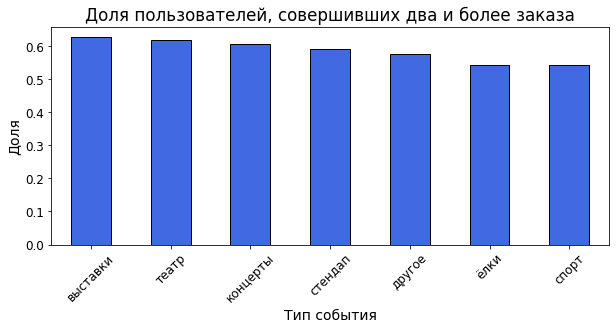

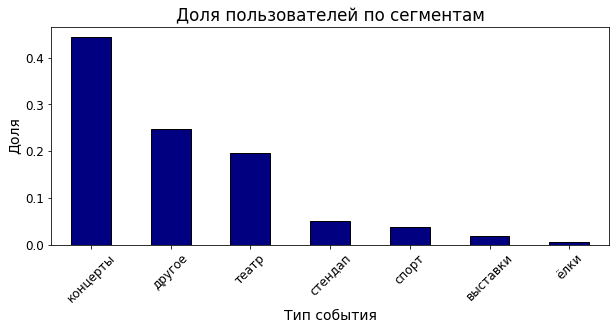

Медиана:  0.5921421889616464
Среднее:  0.5866166292015002
                        count                                
                 total_orders                                
is_two                      0     1 total    share2 share_tot
first_event_type                                             
выставки                  149   250   399  0.626566  0.019124
театр                    1557  2541  4098  0.620059  0.196415
концерты                 3648  5607  9255  0.605835  0.443587
стендап                   436   633  1069  0.592142  0.051237
другое                   2189  2992  5181  0.577495  0.248322
ёлки                       43    51    94  0.542553  0.004505
спорт                     352   416   768  0.541667  0.036810


In [57]:
events[('count', 'total_orders', 'share2')].sort_values(ascending=False).plot(
    kind='bar', 
    xlabel='Тип события', 
    ylabel='Доля', 
    legend=False,
    rot=45, 
    title='Доля пользователей, совершивших два и более заказа', 
    figsize=(10,4),
    fontsize = 12,
    color = ['royalblue'],
    edgecolor='black'
    )
plt.show()

events[('count', 'total_orders', 'share_tot')].sort_values(ascending=False).plot(
    kind='bar', 
    xlabel='Тип события', 
    ylabel='Доля', 
    legend=False,
    rot=45, 
    title='Доля пользователей по сегментам', 
    figsize=(10,4),
    fontsize = 12,
    color = ['navy'],
    edgecolor='black'
    )
plt.show()

print('Медиана: ',events[('count', 'total_orders', 'share2')].median())
print('Среднее: ',events[('count', 'total_orders', 'share2')].mean())
print(events.sort_values(by=events.columns[3], ascending=False))

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> На графики этого типа удобнее было бы добавить `axvline` (`axhline` для устройства, так как там гистограмма вертикальная) со средним уровнем возврата по выборке для более удобного анализа точек входа.

По признаку первое посещенное меропритие чаще всего возвращаются пользователи, посетившие `Выставки`, `Театр`, `Концерты`. При этом доля `Выставок` в общем количестве довольно низкая, что может указывать на нестабильность результата по этому параметру.

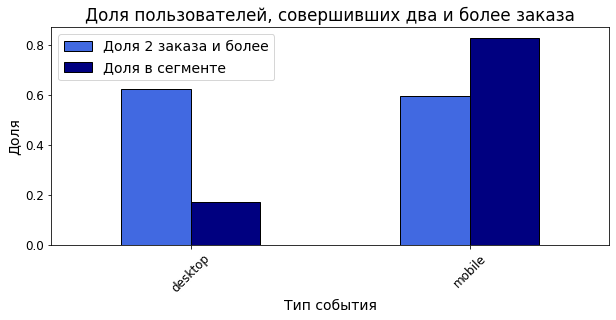

Медиана:  0.6079181082222352
Среднее:  0.6079181082222352


NameError: name 'df_fd' is not defined

In [58]:
##попробуем другой формат представления графиков
device[[('count', 'total_orders', 'share2'),('count', 'total_orders', 'share_tot')]].sort_values(by=device.columns[3], ascending=False).plot(
    kind='bar', 
    xlabel='Тип события', 
    ylabel='Доля', 
    legend=True,
    rot=45, 
    title='Доля пользователей, совершивших два и более заказа', 
    figsize=(10,4),
    fontsize = 12,
    color = ['royalblue','navy'],
    edgecolor='black'
    )
plt.legend(labels=['Доля 2 заказа и более', 'Доля в сегменте'])  # новые подписи
plt.show()

print('Медиана: ',device[('count', 'total_orders', 'share2')].median())
print('Среднее: ',device[('count', 'total_orders', 'share2')].mean())
print(df_fd.sort_values(by=device.columns[3], ascending=False))

Пользователи, сделавшие первый заказ через `desktop` возвращаются лишь немного чаще, но их почти в 5 раз меньше.

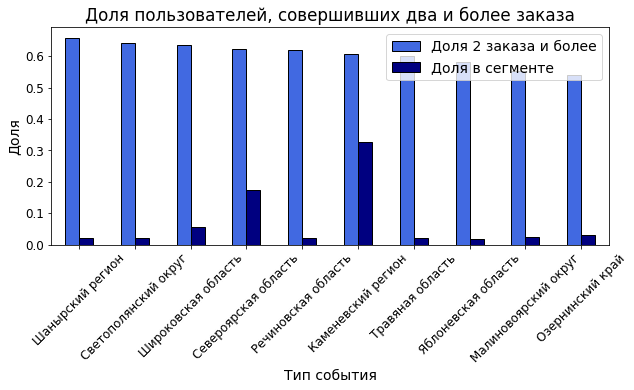

Медиана:  0.5593311758360302
Среднее:  0.5566566242268854
                            count                                    
                     total_orders                                    
is_two                          0       1   total    share2 share_tot
first_region                                                         
Шанырский регион            160.0   310.0   470.0  0.659574  0.022535
Светополянский округ        158.0   283.0   441.0  0.641723  0.021145
Широковская область         434.0   759.0  1193.0  0.636211  0.057202
Североярская область       1357.0  2242.0  3599.0  0.622951  0.172564
Речиновская область         159.0   260.0   419.0  0.620525  0.020090
Каменевский регион         2678.0  4163.0  6841.0  0.608537  0.328011
Травяная область            188.0   282.0   470.0  0.600000  0.022535
Яблоневская область         168.0   233.0   401.0  0.581047  0.019227
Малиновоярский округ        233.0   289.0   522.0  0.553640  0.025029
Озернинский край            304.

In [59]:
region10[[('count', 'total_orders', 'share2'),('count', 'total_orders', 'share_tot')]].head(10).sort_values(by=region10.columns[3], ascending=False).plot(
    kind='bar', 
    xlabel='Тип события', 
    ylabel='Доля', 
    legend=True,
    rot=45, 
    title='Доля пользователей, совершивших два и более заказа', 
    figsize=(10,4),
    fontsize = 12,
    color = ['royalblue','navy'],
    edgecolor='black'
    )
plt.legend(labels=['Доля 2 заказа и более', 'Доля в сегменте'])  # новые подписи
plt.show()

print('Медиана: ',region[('count', 'total_orders', 'share2')].median())
print('Среднее: ',region[('count', 'total_orders', 'share2')].mean())
print(region10.sort_values(by=region10.columns[3], ascending=False))

Наиболее активные регионы представлены в таблице выше в порядке снижения доли пользователей, совершивших не менее двух заказов. Наибольшая доля вернувшихся пользователей - в Шанурском регионе, при этом в Каменевском регионе - наибольшее количество пользователей, но доля пользователей с 2 и более заказами - 6я по счету. 

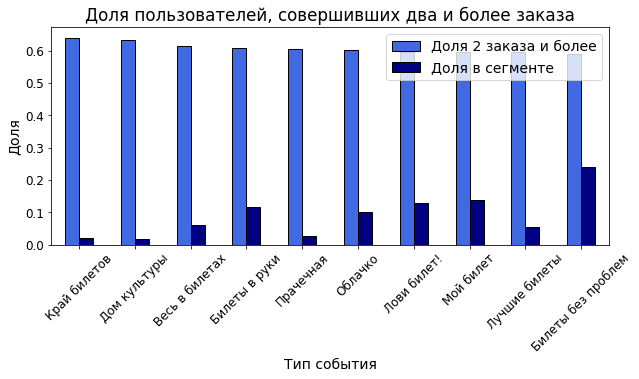

Медиана:  0.5966850828729282
Среднее:  0.5852327500393901


In [60]:
service10[[('count', 'total_orders', 'share2'),('count', 'total_orders', 'share_tot')]].head(10).sort_values(by=service.columns[3], ascending=False).plot(
    kind='bar', 
    xlabel='Тип события', 
    ylabel='Доля', 
    legend=True,
    rot=45, 
    title='Доля пользователей, совершивших два и более заказа', 
    figsize=(10,4),
    fontsize = 12,
    color = ['royalblue','navy'],
    edgecolor='black'
    )
plt.legend(labels=['Доля 2 заказа и более', 'Доля в сегменте'])  # новые подписи
plt.show()

print('Медиана: ',service[('count', 'total_orders', 'share2')].median())
print('Среднее: ',service[('count', 'total_orders', 'share2')].mean())
#print(service10.sort_values(by=service10.columns[3], ascending=False))

In [61]:
service10.sort_values(by=service10.columns[3], ascending=False)

count                                    
                   total_orders                                    
is_two                        0       1   total    share2 share_tot
first_service                                                      
Край билетов              159.0   283.0   442.0  0.640271  0.021186
Дом культуры              125.0   214.0   339.0  0.631268  0.016249
Весь в билетах            480.0   768.0  1248.0  0.615385  0.059819
Билеты в руки             952.0  1472.0  2424.0  0.607261  0.116187
Прачечная                 219.0   335.0   554.0  0.604693  0.026554
Облачко                   841.0  1272.0  2113.0  0.601988  0.101280
Лови билет!              1095.0  1620.0  2715.0  0.596685  0.130135
Мой билет                1167.0  1717.0  2884.0  0.595354  0.138235
Лучшие билеты             458.0   672.0  1130.0  0.594690  0.054163
Билеты без проблем       2051.0  2934.0  4985.0  0.588566  0.238940

У всех операторов из топ-10 по количеству пользователей доля повторных заказов выше среднего. Самые лояльные пользователи - у оператора `Край билетов`, но доля рынка последнего на фоне остальных - не велика. Результаты по таким провайдерам могут быть не стаблильными, варьироваться в зависимости от каких-либо факторов. Например, от сезона. 

<!-- Поэтому, из тех операторов, у которых доля пользователей выше 10%, самая большая доля клиентов с 2 и более заказами - у оператора `Весь в билетах`. Лидерство по абсолютному значению вернувшихся клиентов - у самого крупного  оператора `Билеты без проблем`. -->

По доле рынка операторов можно разделить на несколько кластеров - 1%-2%, 5%-6%, 10%-20% и более 20%. Если рассматривать операторы с долей рынка более 10%, то самая большая доля вернувшихся клиентов - у оператора `Билеты в руки`. Лидерство по абсолютному значению вернувшихся клиентов - у самого крупного  оператора `Билеты без проблем`.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Ты правильно рассчитал ключевые метрики: доли пользователей с повторными заказами внутри каждого сегмента. Верно интерпретируешь данные в контексте размера выборки - справедливо отметил, что высокие показатели в категориях с малым количеством пользователей (например, выставки или оператор Край билетов) могут быть нестабильны.

Выводы по типам устройств и регионам логичны. Ты грамотно подсветил разницу между «количеством» и «качеством» аудитории: самый крупный регион действительно не является лидером по удержанию, а пользователи десктопов возвращаются чаще, несмотря на их меньшее число.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> В блоке с регионами ты указываешь конкретное место (6-е) для самого крупного региона. Это верно, но при описании топа полезно явно перечислять те регионы, которые составляют "ядро" лояльности, чтобы картина была полнее, а не только фокусироваться на лидере списка и самом массовом сегменте.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Самая грубая ошибка допущена в анализе билетных операторов. Ты пишешь, что среди операторов с долей рынка выше 10% лидирует Весь в билетах. Если сложить количество пользователей всех операторов в таблице, получится около 19 000 человек. 10% от этого числа - это 1 900. У оператора Весь в билетах всего 1 248 пользователей, то есть он занимает около 6,6% рынка и не проходит под твой собственный критерий фильтрации. Тебе нужно пересмотреть этот вывод и найти лидера среди тех, у кого действительно больше 10% аудитории (например, Билеты в руки или Облачко).

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Похоже, что ошибся строкой. Правка выше.
</div>

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [62]:
print('Сводная таблица - количество вернувшихся и невернувшихся пользователей в разрезе типа мероприятий:')
display(events)

Сводная таблица - количество вернувшихся и невернувшихся пользователей в разрезе типа мероприятий:


count                                
                 total_orders                                
is_two                      0     1 total    share2 share_tot
first_event_type                                             
выставки                  149   250   399  0.626566  0.019124
другое                   2189  2992  5181  0.577495  0.248322
концерты                 3648  5607  9255  0.605835  0.443587
спорт                     352   416   768  0.541667  0.036810
стендап                   436   633  1069  0.592142  0.051237
театр                    1557  2541  4098  0.620059  0.196415
ёлки                       43    51    94  0.542553  0.004505

**Гипотеза 1** странно сформулирована. 

*Тип мероприятия влияет на вероятность возврата на Яндекс Афишу* - да, влияет. Чаще всего повторные заказы делают пользователи, посетившие выставки, театр и концерты. 

*пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты* - наоборот: повторную покупку пользователи, совершившие первый заказ на спортмеропрития, совершают реже пользователей, первый заказ которых - концерты. 

**Гипотеза 2** не поддерждается - это видно по данным одного из предыдущи графиков. У наиболее активных регионов доля хоть и высокая, но существуют регионы с большей доле повторных заказов.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Ты верно проанализировал данные и пришел к правильным заключениям по обеим гипотезам. Сравнение показателей для спорта и концертов выполнено точно - цифры действительно опровергают предположение о лидерстве спорта, так как показатель удержания там ниже. По второй гипотезе ты также справедливо заметил, что самые массовые регионы уступают по удержанию менее крупным, поэтому прямая связь между активностью региона и возвращаемостью отсутствует.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> 

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

А здесь что дорабатывать?
</div>

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


**Здесь задача некорректно сформулирована: сказано построить распределение выручки с билета, но в скобках указно `avg_revenue_rub`, хотя это средняя выручка с заказа, в котором может быть несколько билетов. В следующей задаче речь снова идет про выручку с заказа**

При расчете моды по признаку `is_two` были выявлены нулевые значения исходного поля `revenue` преимущественно у оператора Билеты без проблем. Нулевые цены будут искажать статистику при работе с показателями выручки. Исключим такие записи из датафрейма. Отрицательные выручки - возвраты - не велики и не многочисленны, можно их оставить.

In [63]:
dff = (df.loc[df['avg_revenue_rub'] != 0]).copy()

In [64]:
#определим стоимость билета и запишем ее в новое поле
dff['avg_ticket_price']=dff['avg_revenue_rub']/dff['avg_tickets_per_order']

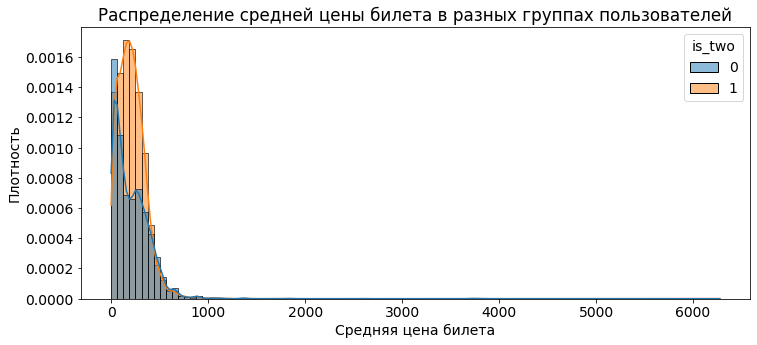

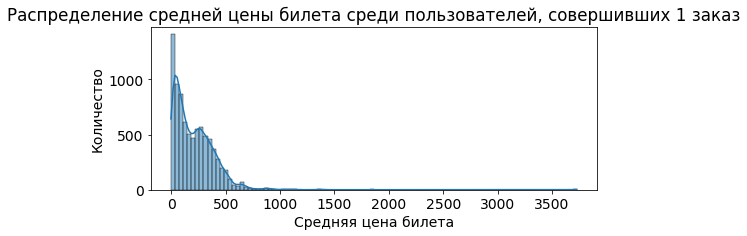

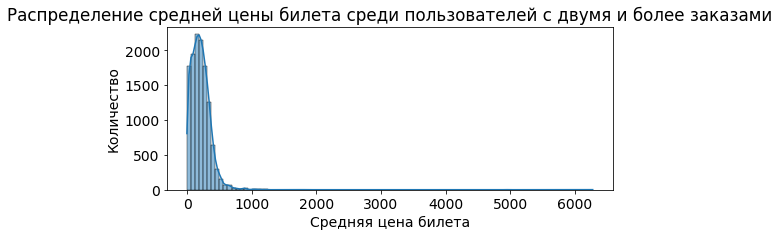

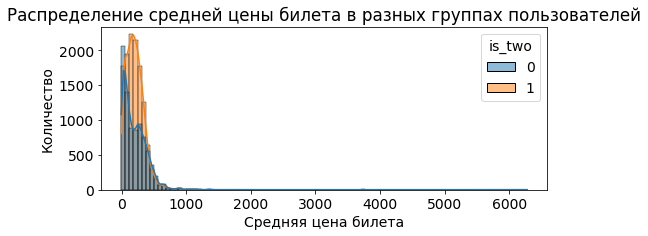

In [65]:
#гистограмма
plt.figure(figsize=(12,5))
sns.histplot(data=dff, x='avg_ticket_price', hue='is_two', bins=100, kde=True, stat='density', alpha=0.5)
plt.fontsize=14
# оранжевый график должен быть для is_two=1. 
#Почему-то задание легенды plt.legend приводит к неожиданной очередности. Поэтому сначала задаем 2+ заказов, потом 1
# так легенда сооветствует автоматически создаваемой
#plt.legend(labels=['2+ заказов','1 заказ'])  
plt.title('Распределение средней цены билета в разных группах пользователей')
plt.xlabel('Средняя цена билета')
plt.ylabel('Плотность')
plt.show()

#гистограмма
plt.figure(figsize=(8,3))
qq=dff.loc[dff['is_two']==0]
sns.histplot(data=qq, x='avg_ticket_price', bins=100, kde=True, stat='count', alpha=0.5)
plt.fontsize=14
plt.title('Распределение средней цены билета среди пользователей, совершивших 1 заказ')
plt.xlabel('Средняя цена билета')
plt.ylabel('Количество')
plt.show()

#гистограмма
plt.figure(figsize=(8,3))
ww=dff.loc[dff['is_two']==1]
sns.histplot(data=ww, x='avg_ticket_price', bins=100, kde=True, stat='count', alpha=0.5)
plt.fontsize=14
plt.title('Распределение средней цены билета среди пользователей с двумя и более заказами')
plt.xlabel('Средняя цена билета')
plt.ylabel('Количество')
plt.show()

plt.figure(figsize=(8,3))
sns.histplot(data=dff, x='avg_ticket_price', hue='is_two', bins=100, kde=True, stat='count', alpha=0.5)
plt.fontsize=14
plt.title('Распределение средней цены билета в разных группах пользователей')
plt.xlabel('Средняя цена билета')
plt.ylabel('Количество')
plt.show()

Распределение пользователей обеих групп пользователей - скошенное вправо: практически все покупатели из обеих групп делают покупки до 1000 руб.  Большинство - до ~600 руб. 
Пики распределения находятся рядом, но у второй группы пик смещен вправо Это может указывать на то, что лояльные пользователи чаще склонны к более дорогим покупкам. Но разница между группами потребителей хоть и заметна, не выглядит существенной.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Ты проявил внимательность и заметил несоответствие в описании задачи: просили выручку с билета, а переменную указали для выручки с заказа. Решение рассчитать честную стоимость билета через деление на количество билетов - отличное, это показывает, что ты критически подходишь к данным, а не просто следуешь инструкции.

Также правильно сделано, что ты отфильтровал нулевые значения, чтобы не искажать статистику, и использовал график плотности (KDE). Поскольку выборка разовых пользователей значительно больше выборки лояльных, сравнивать их на обычной гистограмме по абсолютному количеству было бы сложно, а график плотности решает эту проблему.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> 

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Вывод получился слишком общим. В задании был конкретный вопрос: «В каких диапазонах средней выручки концентрируются пользователи из каждой группы?». Тебе стоило указать цифры, например, что основная масса покупок у обеих групп лежит в диапазоне от 0 до определенной суммы.

Утверждение, что возвращающиеся пользователи покупают более дорогие билеты, стоит уточнить. Судя по графику плотности, пики у обеих групп находятся очень близко, просто у лояльных пользователей график чуть смещен вправо, и меньше доля совсем дешевых покупок. Разница есть, но она не выглядит кардинальной — это скорее нюанс распределения, чем явное предпочтение дорогого сегмента.

На сборном графике с тремя гистограммами у второго и третьего графика одинаковые заголовки - похоже на ошибку копирования.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

    Правка - выше, перед комментарием

</div>

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [66]:
dff['is_two_four'] = 0
dff.loc[dff['total_orders'] <= 1, 'is_two_four'] = 0
dff.loc[(dff['total_orders'] >= 2) & (dff['total_orders'] <= 4), 'is_two_four'] = 1
dff.loc[dff['total_orders'] >= 5, 'is_two_four'] = 2

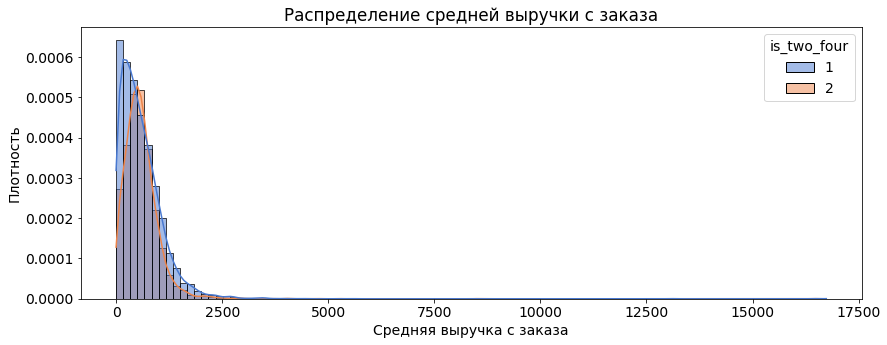

In [67]:
#гистограмма
plt.figure(figsize=(14,5))
aa=dff[dff['is_two_four'] >= 1]
sns.histplot(data=aa, x='avg_revenue_rub', hue='is_two_four', 
             palette='muted',
             bins=100, kde=True, stat='density', alpha=0.5)
plt.fontsize=14
plt.title('Распределение средней выручки с заказа')
plt.xlabel('Средняя выручка с заказа')
plt.ylabel('Плотность')
plt.show()

Мода средней выручки с пользователей, совершивших 5 и более заказов, ниже аналогичного значения для пользователей с 2-4 заказами:

In [68]:
dff.groupby('is_two_four')['avg_revenue_rub'].apply(lambda x: x.mode())

is_two_four   
0            0      31.580
1            0    1380.575
2            0     990.560
Name: avg_revenue_rub, dtype: float64

Большинство пользователей первой группы (2-4 заказа) приносят минимальную среднюю выручку. С ростом выручки число пользователей резко снижается. 
Характер распределения средней выручки для пользователей 2й группы (5+ заказов) несколько иной: сначала с ростом выручки число пользователей растет, затем после достижения максимальных значений снижается сильнее, чем у пользователей 1 группы. 
Пользователи из 2й группы чаще приносят бОльшую среднюю выручку.

In [69]:
dff.groupby(['is_two_four'])['avg_revenue_rub'].mean()

is_two_four
0    573.580686
1    582.666210
2    585.232898
Name: avg_revenue_rub, dtype: float64

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?
    
Значение средней выручки для покупателей с 5 и более заказами несущественно выше аналогичного значения для группы пользователей с 2-4 заказами - 585 руб. против 582.7 руб. 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Ты выбрал правильный тип графика для сравнения распределений. Поскольку количество пользователей в группах разное, обычная гистограмма могла бы исказить восприятие, а плотность позволяет корректно сравнить структуру данных.

Расчет средних значений во второй части выполнен верно. Вывод о том, что средний чек между группами лояльных и «средних» пользователей практически не отличается (разница всего в 3 рубля), полностью подтверждается цифрами.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Описание графика выглядит немного притянутым. Ты пишешь, что характер распределения «несколько иной» и для второй группы наблюдается рост, а затем снижение. Визуально оба графика имеют очень схожую форму (скошенное вправо распределение) - пик находится в начале, а затем идет длинный хвост. Различия в форме кривых минимальны и скорее говорят о том, что структура трат у этих групп одинаковая, чем о каких-то принципиальных различиях в поведении.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [70]:
dff['avg_tickets_per_order'].max()

12.0

In [71]:
dff['ticket_group'] = pd.cut(dff['avg_tickets_per_order'], bins=[1,2,3,5,100], right=False, labels=['1-2 билета','2-3 билета','3-5 билетов','5< билетов'])

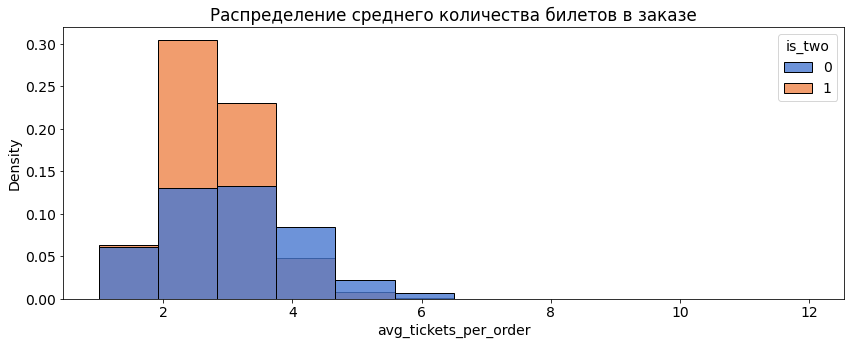

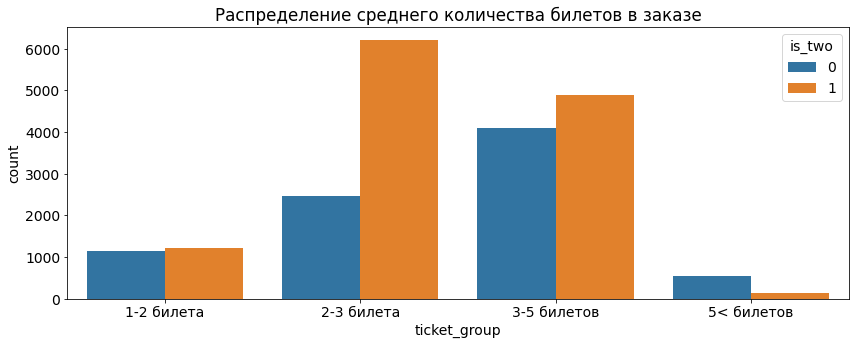

In [72]:
plt.figure(figsize=(14,5))
sns.histplot(data=dff, x='avg_tickets_per_order', hue='is_two', 
             palette='muted',
             bins=12, kde=False, stat='density', alpha=0.8)
plt.fontsize=14
plt.title('Распределение среднего количества билетов в заказе')
plt.show()

plt.figure(figsize=(14,5))
sns.countplot(data=dff, x='ticket_group', hue='is_two'  )
plt.fontsize=14
plt.title('Распределение среднего количества билетов в заказе')
plt.show()


<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Для анализа распределения дискертного признака нужен тип графиков, который на каждое уникальные значение признака строит свою корзину. Например, можно использовать `sns.countplot`.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Перенёс разделение на группы на предыдущий шаг, т.к. countplot не работает без категорий
</div>

Пользователи, совершившие 2+ заказа, чаще покупают 2-4 билета. Совершившие 1 заказ - также 2-4 билета, но доля таких ниже. Распределение пользователей с одним заказом болшее равномерное - чаще готовы покупать ~4 билета. Доли покупателей с заказом менее двух билетов примерно одинаковые в обеих группах пользователей.

Разделим пользователей на несколько сегментов по среднему количеству билетов в заказе:
- от 1 до 2 билетов - группа A;
- от 2 до 3 билетов - группа B; 
- от 3 до 5 билетов - группа C;
- от 5 и более билетов - группа D.

В сводной таблице посчитаем:
 - каждого сегмента общее число пользователей
 - долю пользователей, совершивших повторные заказы.

In [73]:
#разделение на группы перенес на предыдущий шаг

In [74]:
#проверка на пропуски
dff.loc[dff['ticket_group'].isna()==True]['avg_tickets_per_order']
dff['ticket_group'].value_counts().sum() #???

20728

In [75]:
pt = pd.pivot_table(data=dff, index='ticket_group', values=['total_orders'], columns='is_two', aggfunc=['count'])
ticket_group = pd.DataFrame(pt)
ticket_group[('count', 'total_orders', 'total')] = ticket_group[('count', 'total_orders', 0)]+ticket_group[('count', 'total_orders', 1)]
ticket_group[('count', 'total_orders', 'share2')] = ticket_group[('count', 'total_orders', 1)]/(ticket_group[('count', 'total_orders', 0)]+ticket_group[('count', 'total_orders', 1)])
ticket_group

count                      
             total_orders                      
is_two                  0     1 total    share2
ticket_group                                   
1-2 билета           1151  1221  2372  0.514755
2-3 билета           2465  6211  8676  0.715883
3-5 билетов          4106  4890  8996  0.543575
5< билетов            551   133   684  0.194444

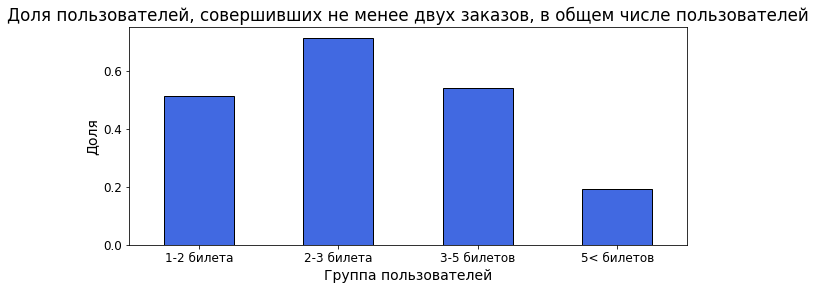

In [76]:
ticket_group[('count', 'total_orders', 'share2')].plot(
    kind='bar', 
    xlabel='Группа пользователей', 
    ylabel='Доля', 
    legend=False,
    rot=0, 
    title='Доля пользователей, совершивших не менее двух заказов, в общем числе пользователей', 
    figsize=(10,4),
    fontsize = 12,
    color = ['royalblue'],
    edgecolor='black'
    )
plt.show()

Ответьте на вопросы:

Как распределены пользователи по сегментам — равномерно или сконцентрировано?
- Пользователи распределены неравномерно. 

Есть ли сегменты с аномально высокой или низкой долей повторных покупок?
- Немногим больше 50% пользователей в группах A (1-2 билетов) и С (3-5 билетов) совершают две и более покупки (заказа)
- ~72% пользователей, купивших 2-3 билета совершают не менее 2 заказов - можно считать показатель аномально высоким.
- Только 19% пользователей с заказами с более, чем 5 билетов, возвращаются за повторной покупкой.

Последняя наименее лояльная группа D - вероятно большие компании, тургруппы, оптовые покупки и тд. 


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Ты правильно выполнил сегментацию пользователей и верно рассчитал целевую метрику - долю повторных заказов (share2) для каждой группы. Таблица получилась информативной: по ней сразу видно, что ядро аудитории - это группы B (2-3 билета) и C (3-5 билетов), в то время как группы A и D значительно меньше.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> Самый важный инсайт, который ты упустил в текстовом выводе - это аномально низкая возвращаемость в группе D (5 и более билетов). В таблице видно, что их share2 всего ~19%, что в разы меньше, чем у остальных (50-70%). Это и есть ответ на вопрос задачи про сегменты с аномалиями. Скорее всего, это оптовые закупки или разовые групповые походы (школы, тургруппы), и для бизнеса важно понимать, что эти клиенты почти не возвращаются.

Визуализацию на последнем графике (столбчатая диаграмма) лучше делать логически упорядоченной. Сейчас группы идут вперемешку (B, C, A, D), вероятно, по убыванию значений. Гораздо нагляднее расположить их в естественном порядке количества билетов (A → B → C → D). Это позволило бы сразу увидеть паттерн: низкая лояльность у одиночек → пик лояльности у пар/семей → резкое падение у больших групп. Также подписи на оси X лучше заменить с букв на понятные интервалы ("1-2 билета" и т.д.).

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Про группу D я пишу в третьем буллите, а в комментарии к выводам в конце вы это тоже отмечаете: 
    
`Только 19% пользователей с заказами с более, чем 5 билетов, возвращаются за повторной покупкой.`

Дополнил комментарием, что это чаще всего групповые покупки, которые не возращаются под тем же id.

Переименовал категории A,B,C,D на "1-2 билета" и т.д. и убрал сортировку по убыванию доли.
</div>

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [77]:
# Определяем номер днянедели
dff['weekday'] = dff['first_order_dt'].dt.weekday + 1

In [78]:
pt = pd.pivot_table(data=dff, index='weekday', values=['total_orders'], columns='is_two', aggfunc=['count'])
week_day = pd.DataFrame(pt)
week_day[('count', 'total_orders', 'total')] = week_day[('count', 'total_orders', 0)]+week_day[('count', 'total_orders', 1)]
week_day[('count', 'total_orders', 'share2')] = week_day[('count', 'total_orders', 1)]/(week_day[('count', 'total_orders', 0)]+week_day[('count', 'total_orders', 1)])
week_day

count                      
        total_orders                      
is_two             0     1 total    share2
weekday                                   
1               1069  1741  2810  0.619573
2               1198  1841  3039  0.605791
3               1148  1814  2962  0.612424
4               1252  1771  3023  0.585842
5               1290  1867  3157  0.591384
6               1222  1883  3105  0.606441
7               1094  1538  2632  0.584347

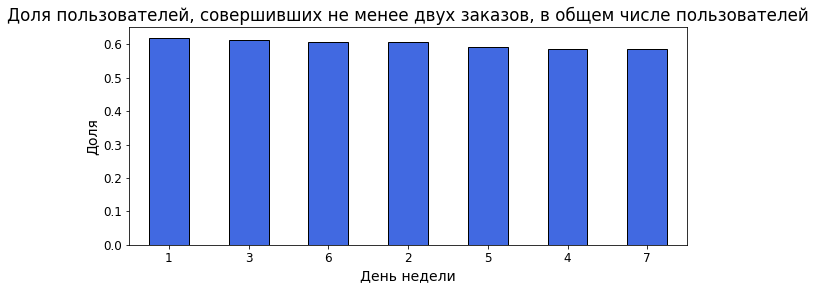

In [79]:
week_day[('count', 'total_orders', 'share2')].sort_values(ascending=False).plot(
    kind='bar', 
    xlabel='День недели', 
    ylabel='Доля', 
    legend=False,
    rot=0, 
    title='Доля пользователей, совершивших не менее двух заказов, в общем числе пользователей', 
    figsize=(10,4),
    fontsize = 12,
    color = ['royalblue'],
    edgecolor='black'
    )
plt.show()

День недели не влияет на вероятность возврата пользователя

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Ты верно выполнил техническую часть: сгруппировал данные по дням недели и рассчитал долю вернувшихся пользователей. Вывод соответствует полученным цифрам - разброс значений действительно минимален (в пределах нескольких процентов), что позволяет говорить об отсутствии сильного влияния дня недели на лояльность.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> В таблице дни недели остались в формате цифр. Для удобства восприятия лучше заменять их на текстовые названия (Понедельник, Вторник...), чтобы читателю не приходилось в уме сопоставлять цифры с календарем. Также можно немного расширить вывод, отметив небольшую тенденцию к снижению доли возвратов к выходным, даже если она статистически незначима.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [80]:
dff['btw_ord_group'] = pd.cut(dff['total_orders'], bins=[1,2,5,100], right=False, labels=['1 заказ','2-4 заказа','5+ заказов'])

In [81]:
dff['btw_ord_group'].isna().sum()

0

In [82]:
pt_btw = pd.pivot_table(data=dff, index='btw_ord_group', values=['avg_days_between_orders'], aggfunc=['mean'])
df_btw = pd.DataFrame(pt_btw)
print('Рассчитайте среднее время между заказами для двух групп пользователей:')
df_btw

Рассчитайте среднее время между заказами для двух групп пользователей:


,mean
,avg_days_between_orders
btw_ord_group,
2-4 заказа,21.395944
5+ заказов,11.159396


In [83]:
dff['avg_days_between_orders'].max()

148.0

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_statistics.py:356: RuntimeWarning: invalid value encountered in true_divide
  hist = hist.astype(float) / hist.sum()


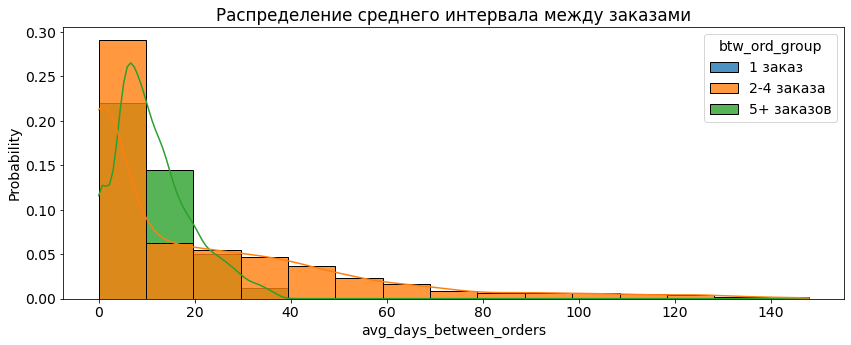

In [84]:
plt.figure(figsize=(14,5))
sns.histplot(data=dff, x='avg_days_between_orders', hue='btw_ord_group', 
             bins=15, kde=True, stat='probability', alpha=0.8)
plt.fontsize=14
plt.title('Распределение среднего интервала между заказами')
plt.show()

Вероятность того, что пользователь сделает повторный заказ снижается по мере увеличения интервала между заказами. Первые 10 дней - наиболее важные: для группы 2-4 заказа вероятность возврата составляет чуть менее 30%. К концу второй декады вероятность снижается до 5%. 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Ты верно выполнил все этапы задачи. Результаты расчетов показывают сильную и логичную связь: пользователи, совершившие 5 и более заказов, имеют вдвое меньший средний интервал между покупками (11.16 дня) по сравнению с группой 2–4 заказов (21.40 дня).

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> В финальном выводе стоит явно связать два ключевых результата. Сейчас ты их представил отдельно. Анализ будет сильнее, если ты прямо укажешь, что группа пользователей с 5+ заказами (11.16 дня) попадает в критически важный интервал (до 20 дней), что и обеспечивает им высокую лояльность, в то время как средний интервал группы 2–4 заказа (21.40 дня) уже находится в зоне низкого удержания.

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку❌:</b> График выше показывает относительное распределение значений `avg_days_between_orders`, но ничего не говорит о склонности к возврату. Тут стоит визуализировать распределение `avg_days_between_orders` в разрезе групп, чтобы видеть влияние `avg_days_between_orders` на возврат.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>

Перерисовал график в разрезе групп

</div>

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [85]:
#содаем новый столбец для сегментации пользователей по total_orders
dff['total_orders_segment'] = pd.cut(dff['total_orders'], bins=[1,2,5,1000], right=False, labels=['A','B','C'])
print('Проверка пропусков в новом поле total_orders_segment:',dff['total_orders_segment'].isna().sum())
#Формируем два датафрейма с ограниченным перечнем полей для сравнения матриц корреляций
df_corr1 = dff[['total_orders','first_device','first_region','first_service','first_event_type','avg_revenue_rub',
                'avg_tickets_per_order','avg_days_between_orders','avg_ticket_price']]
df_corr2 = dff[['total_orders_segment','first_device','first_region','first_service','first_event_type','avg_revenue_rub',
                'avg_tickets_per_order','avg_days_between_orders','avg_ticket_price']]

int_cols1=['total_orders','avg_revenue_rub','avg_tickets_per_order','avg_days_between_orders','avg_ticket_price']
int_cols2=['avg_revenue_rub','avg_tickets_per_order','avg_days_between_orders','avg_ticket_price']
corr_matrix1 = df_corr1.phik_matrix(interval_cols=int_cols1)
corr_matrix2 = df_corr2.phik_matrix(interval_cols=int_cols2)

Проверка пропусков в новом поле total_orders_segment: 0


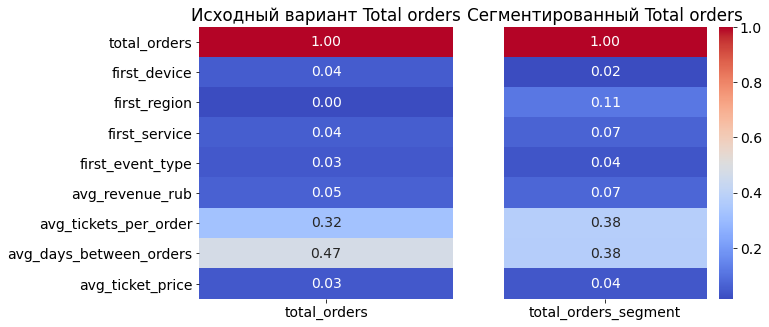

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Исходный вариант Total orders')
ax2.set_title('Сегментированный Total orders')
sns.heatmap(corr_matrix1[['total_orders']], ax=ax1, cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
sns.heatmap(corr_matrix2[['total_orders_segment']], ax=ax2, cmap='coolwarm', annot=True, fmt='.2f', cbar=True, yticklabels=False)
plt.show()

Наибольшая связь с количеством заказов прослеживается у полей `"Среднее количество дней между заказами/avg_days_between_orders"` `"Среднее количество билетов в заказе/avg_tickets_per_order"`. Оценка влияния этих факторов на вероятность возврата приведена в предыдущих пунктах.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Ты отлично справился с технической частью задания: рассчитал корреляцию и, что важно, выполнил требование по сегментации количества заказов. Сравнительная тепловая карта наглядно показывает, как меняются коэффициенты при переходе от непрерывной переменной к интервальной.

Вывод корректен и полностью опирается на данные графика: ты безошибочно выделил признаки с наибольшей связью - среднее количество дней между заказами и количество билетов.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> Обрати внимание на то, как изменилась корреляция для признака first_region (регион). В первом столбце она была нулевой (0.00), а после сегментации выросла до 0.11. Хотя связь осталась слабой, этот скачок подтверждает гипотезу из задания: разбиение на группы помогает выявить скрытые зависимости, которые теряются при анализе «в лоб». Стоило упомянуть этот момент, так как он демонстрирует пользу проведенной тобой сегментации.

Также есть небольшая опечатка в текстовом выводе под графиком: «коичество» вместо «количество».

Касательно лидера корреляции - среднего количества дней между заказами. Здесь стоит быть аккуратнее с интерпретацией. Эта связь во многом техническая: чтобы посчитать среднее количество дней между заказами, у пользователя должно быть минимум два заказа. То есть наличие значения в этом поле уже подразумевает, что заказов больше одного. Это так называемая утечка данных (data leakage), о чем полезно помнить при продуктовом анализе.

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
Количество поправил, спасибо) 
    
Да, скачок 0.00 - 0.11 сразу заметил. Но, т.к. связь совсем слабая, про этот эффект упоминать не стал. Вообще ожидал увидеть более сильные связи. На мой взгляд 0.38 тоже довольно таки слабая связь.  
</div>

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

В соответствии с заданием с помощью SQL на основе данных таблиц БД Афиша был собран датасет с данными о заказах Афиши. Количество строк - ~291 тыс. Для конвертации курса казахской тенге в рубли использовался датасет (357 строк), содержащий выгрузку данных о динамике курса валюты по данным сайта ЦБ. Датасеты были объединены в один, выручка в тенге конвертирована в рубли. Из объединенного датасета были исключены строки со слишком высокими значениями выручки. Фильтрация по 99 перцинтилю позволила снизить искажения статистики и сделало более равномерным распредедение заказов по типам меропритий.

После предварительной обработки был сформирован новый датасет - профиль пользователя, содержащий агргированные данные по каждому пользователю. Новый датасет также был отфильтрован по 95% процентилю - для исключения из анализа пользователей с аномально большими заказами. 
Т.к. для части пользователей значения в поле `выручка/avg_revenue_rub` равнялись нулю, то для анализа показателей, связанных с выручкой соответствующие строки также были отфильтрованы. 

Для целей проведения аналитических расчетов в ходе выполнения проекта были созданы дополнительные поля, позволяющие категоризировать данные о пользователях в различных разрезах. Основое поле из дополнительных - `is_two`, содержащее указание на то, что пользователь совершал более одного заказа. Наличие в этом поле значения, равного единице, указаывает, что пользователь вернулся в сервис. 

*Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?*
    
    Обновленные данные после фильтрации по 95 процентилю:
- Общее число пользователей в выборке:  20864. Пользователи по числу заказов распределены неравномерно. С ростом числа заказов, количество пользователей экспоненциально снижается. 
- Средняя выручка с одного заказа:  581.11 руб.
- 60% пользователей вернулись. При этом 26% совершили 5 и более заказов.
- Пользователи чаще всего совершали 2 заказа, заказывая в среднем чуть менее 3 билетов. Медианное значение периода между заказами - 9 дней. При этом среднее - 17, т.к. в выборке есть пользователи с длительными периодом между заказами (несколько месяцев)

*Какие признаки первого заказа связаны с возвратом пользователей?*
    
    С возвратом пользователей связаны количество билетов в заказе, тип мероприятия, устройство, регион и оператор.
- Чаще всего возвращаются пользователи, посетившие концерты, театры и "другое" (вероятно, что эту категорию можно детализировать).
- Доля вернувшихся пользователей различается по регионам и операторам. 
- Пользователей, совершающих первый заказ с компьютера меньше, чем пользователей, совершающих заказы с мобильных устройств. Но возвращаются desktop-пользователи немного чаще. 

*Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?*
    
- С ростом средней выручки количество пользователей ожидаемо снижается. Но характер распределения разный у разных групп пользователей: большинство пользователей, сделавших только 1 заказ, приносят минимальную выручку, а далее с ростом выручки количество пользователей экспоненциально снижается. 
- В группе пользователей с 2 и более заказами наблюдается несколько иная динамика: минимальную среднюю выручку формирует небольшое количество пользователей. Далее, с ростом выручки количество пользователей увеличивается и, достигнув пика, начинается снижаться аналогично динамике первой группы. Вероятно пользователи, сделавшие несколько заказов, имеюют более высокие доходы, т.к. предпочитают посещение более дорогих мероприятий. 

 - Чаще всего возвращаются пользователи, покупающие 2-3 билета (72% вернувшихся). Второе место - у группы покупателей 3-5 билетов (54%), третье - 1-2 билета (51%), четвертое - 5+ билетов (19%) (вероятно группа сама по себе не многочисленна)

*Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?*

    День недели практически не влияет на удержание: доля вернувшихся пользователей колеблется около 60% +/-2%. 
    
    Интервалы между покупками влияют существенно: вероятность экспоненциально снижается с ростом инетрвала. Наиболее критичными являются первые 10 дней: вероятность возврата составляет 50%. За следующие 10 дней вероятность снижается до 20% и т.д.

*Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?*

    Корреляционный анализ показал, что наибольшую связь с `количеством заказов` имеют признаки `среднее количество дней между заказами` и `среднее количество билетов в заказе`.

**Рекомендации**

Общий принцип рекомендаций: Максимизировать эффект сильных качеств, улучшить показатели по отстающим направлениям.
    Необходимо работать над улучшением качества мероприятий, доступных на платформе. Интерфейс и логика работы приложения должна быть доработана таким образом, чтобы чаще вызывать желание пользователя сделать повторный заказ. При этом важно не допускать излишней навязчивости. 

1. Необходимо провести детальный анализ регионов с меньшей долей возвратов пользователей. Возможно, что качество мероприятий, доступных на платформе оставляет желать лучшего. 
2. Аналогичная рекомендация по операторам: должна быть разработана/улучшена система работы с операторами, введены специальные стимулирующие меры и т.д.
3. Анализ показал, что возвращаются пользователи, предположительно, с большим доходом (выше средняя вырычка - больше покупают более дорогие мероприятия). Вероятно, нужно дополнительно оценить необходимость концентрации на мероприятиях более высокой ценовой категории. Точнее, на - расширении перечня таких мероприятий. 
4. При выявлении соответствуюещей необходимости проводить модернизацию интерфейса приложения/сайта.
5. Т.к. количество дней сильно влияет на возврат пользователей, необходимо провести дополнительный анализ: нужно определить, что конкретно заставляет пользователя вернуться за следующим заказом в разрезе категорий мероприятий. По итогам провести соотвествующую доработку приложения и модернизировать алгоритмы отбора мероприятий. 
6. Между значимыми изменениями в работе проекта необходимо проводить A/B тестирование, внедрять изменения поэтапно для разных групп пользователей. 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Все обязательные пункты, перечисленные в задании, раскрыты в общем выводе:

1. Информация о данных: Ты описал исходный объем, конвертацию тенге в рубли, а также ключевые этапы подготовки данных: фильтрацию выбросов по 95-му перцентилю и исключение нулевых значений.

2. Основные статистические показатели: Указано общее количество пользователей (20 864), неравномерное распределение по числу заказов и медианный интервал между покупками (9 дней).

3. Признаки первого заказа: Верно отмечено, что на лояльность влияют количество билетов, тип мероприятия, устройство, регион и оператор.

4. Билеты в заказе: Точно названа аномалия - пользователи, покупающие 2-3 билета, самые лояльные (72% возврата), а пользователи с 5+ билетами имеют аномально низкий возврат (19%).

5. Выручка: Обоснован вывод о том, что пользователи с 2+ заказами предпочитают более дорогие мероприятия (что коррелирует с их доходом).

6. Временные характеристики: Подтверждено, что день недели не влияет на удержание, а интервалы между покупками влияют существенно, что является одним из главных выводов.

7. Корреляционный анализ: Верно выделены два наиболее связанных с количеством заказов признака: среднее количество дней между заказами и среднее количество билетов в заказе.
    
Предложенные рекомендации логически вытекают из результатов анализа.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

https://github.com/dimaxi1007/afisha

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> В репозитории корректно размещены все нужные файлы проекта, подключение к базе данных выполняетяс из файла `.env`.

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации⚠️:</b> В `README.md` можно добавить итоговый вывод проекта.

<div style="border:solid Chocolate 2px; padding: 40px">

# Комментарий ревьюера: общий вывод по проекту.

Дмитрий, проект получился на довольно хорошем уровне - отличная работа над проектом, молодец!

Мне нравится твой аналитический подход к выполнению проекта, ты соблюдаешь структуру работы, выполняешь её последовательно - это очень хорошо! Шаги проекта выполнены по порядку согласно плану проекта, нет смысловых и структурных ям. Важно, что не забываешь про выводы.
    
Над проектом ещё стоит поработать - есть рекомендации по дополнению некоторых твоих шагов проекта. Такие рекомендации я отметил жёлтыми комментариями. Будет здорово, если ты учтёшь их - так проект станет структурно и содержательно более совершенным.
    
Также в работе есть критические замечания. К этим замечаниям я оставил пояснительные комментарии красного цвета, в которых перечислил возможные варианты дальнейших действий. Уверен, ты быстро с этим управишься:)
    
Если о том, что нужно сделать в рамках комментариев, будут возникать вопросы - оставь их, пожалуйста, в комментариях, и я отвечу на них во время следующего ревью.
    
Также буду рад ответить на любые твои вопросы по проекту или на какие-либо другие, если они у тебя имеются - оставь их в комментариях, и я постараюсь ответить:)
    
Жду твой проект на повторном ревью. До встречи:)